In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## preprocess

In [117]:
import os
from glob import glob
import pygrib

files = glob('/portal1/dell/li-b/ERA5_RN/*.grib')
arr0 = np.zeros(((252,121,141)))

for i, f in enumerate(files):
    grbs = pygrib.open(f)
    grb = grbs.select(name='Surface net short-wave (solar) radiation')[0]
    arr0[i,:,:] = grb.values.data
    
lats, lons = pygrib.open(files[0]).select(name='Surface net short-wave (solar) radiation')[0].latlons()
times = pd.date_range('2002-01-01', '2022-12-31', freq='M')
ds = xr.Dataset({'vari': (['time','lat','lon'], arr0)},
                      coords={'time': (['time'], times.values), 
                              'lat': (['lat'], lats[:,0]),
                      'lon': (['lon'], lons[0,:]),})
ds

<xarray.Dataset>
Dimensions:  (time: 252, lat: 121, lon: 141)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat      (lat) float64 35.0 34.9 34.8 34.7 34.6 ... 23.4 23.3 23.2 23.1 23.0
  * lon      (lon) float64 109.0 109.1 109.2 109.3 ... 122.7 122.8 122.9 123.0
Data variables:
    vari     (time, lat, lon) float64 8.753e+06 8.751e+06 ... 9.999e+03

In [123]:
ds1 = ds['vari'].where(ds['vari']!=9999.0, np.nan).to_dataset()
ds2 = ds1['vari'].sel(lat=slice(34,24.5), lon=slice(110.5,122)).to_dataset()
ds2.to_netcdf('/portal1/dell/li-b/ERA5_RN/RN.nc')

## area mean

In [2]:
ds0 = xr.open_dataset('/portal1/dell/li-b/ERA5_RN/RN_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5) 
arr = ds0['vari'].values.copy()
arr[:,169:,200:] = np.nan
ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds1 = ds00.sel(time=slice('2002-06-30','2022-12-31'))

In [4]:
ds1.to_netcdf('/portal1/dell/li-b/multiregression/rn1.nc')

In [3]:
def cal_month_ano_aver(ds1, mon):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon]))
    ds_m = ds_m0['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_m0.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [4]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_ano7.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [58]:
ds_ano6 = cal_month_ano_aver(ds1, 6)

In [5]:
ds_ano7 = cal_month_ano_aver(ds1, 7)
ds_ano8 = cal_month_ano_aver(ds1, 8)
ds_ano9 = cal_month_ano_aver(ds1, 9)
ds_ano789 = cal_3month_ano_aver(ds1, 7, 8, 9)

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [6]:
ds_ano789.to_netcdf('/portal1/dell/li-b/multiregression/rn.nc')

In [15]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-6.211974e+05,-1.004887e+06,2.573231e+05,-4.533886e+05
1,2003-12-31,1.364173e+06,-9.468764e+05,7.745102e+05,3.998474e+05
2,2004-12-31,1.139065e+06,-4.112098e+05,8.932021e+05,5.426444e+05
3,2005-12-31,6.291062e+05,-1.328071e+06,4.000958e+05,-9.761762e+04
4,2006-12-31,-8.249212e+05,1.661354e+06,2.262009e+05,3.559303e+05
5,2007-12-31,7.126922e+05,-1.995862e+05,-3.503168e+05,5.569554e+04
6,2008-12-31,-6.288174e+04,9.130356e+04,3.570971e+05,1.296523e+05
7,2009-12-31,-1.920503e+05,-3.398363e+05,7.321059e+04,-1.520325e+05
8,2010-12-31,-9.097956e+05,1.569636e+06,-1.329617e+06,-2.226861e+05
9,2011-12-31,6.075970e+05,-3.436010e+05,-7.394991e+05,-1.582145e+05


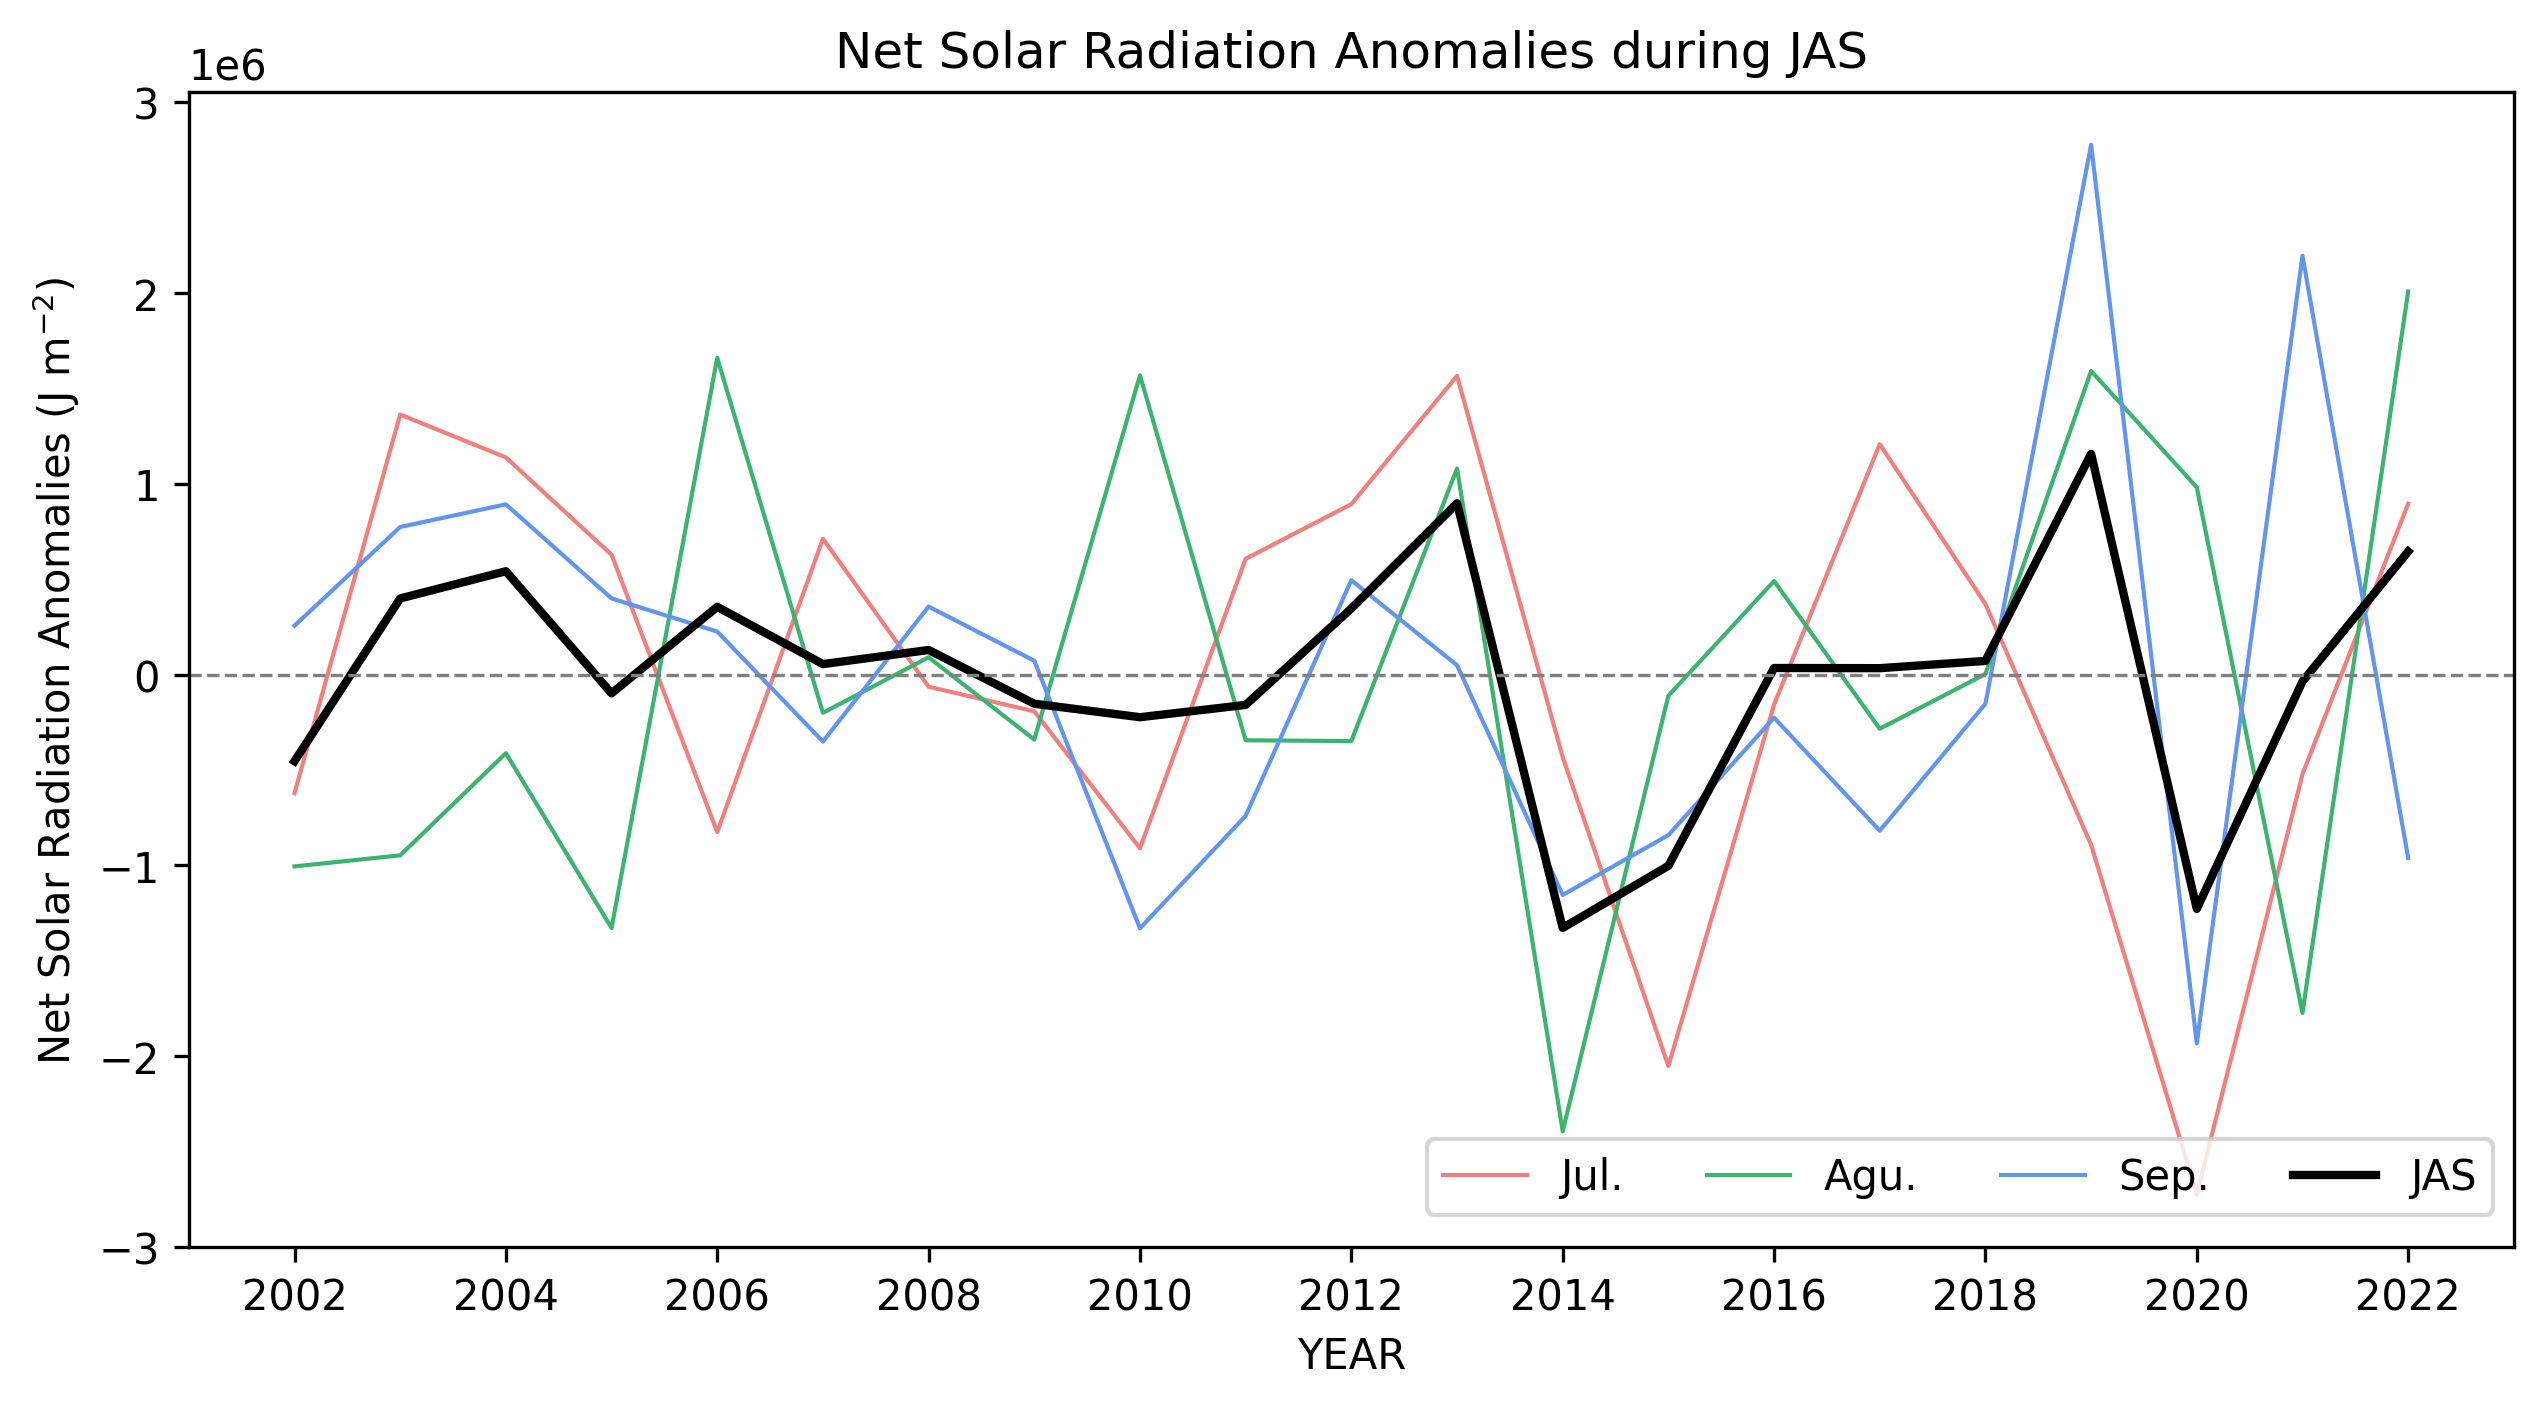

In [17]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='lightcoral',lw=1, ls='-', label='Jul.')
ax.plot(date, v2,color='mediumseagreen',lw=1, ls='-', label='Agu.')
ax.plot(date, v3,color='cornflowerblue',lw=1, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')

ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
ax.set_title('Net Solar Radiation Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)
                        
plt.show()

## spatial plot

In [18]:
d7_0 = ds_ano7['vari'].sel(time='2022-07-31').values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].sel(time='2022-08-31').values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].sel(time='2022-09-30').values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].sel(time='2022-07-31').values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

2215545.7625905685 -522230.32040427835 3736518.5944614746 -954202.9356191903
4625551.435695113 -653571.6690273329 3849767.0145325176 -84584.62499705702
741298.9582338771 -2552864.129024175 1349597.9983576238 -3335711.7521027476
1627990.752562233 -346378.554673129 1691856.2624570187 -434615.25474224985


/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS Net Solar Radiation Anomalies')

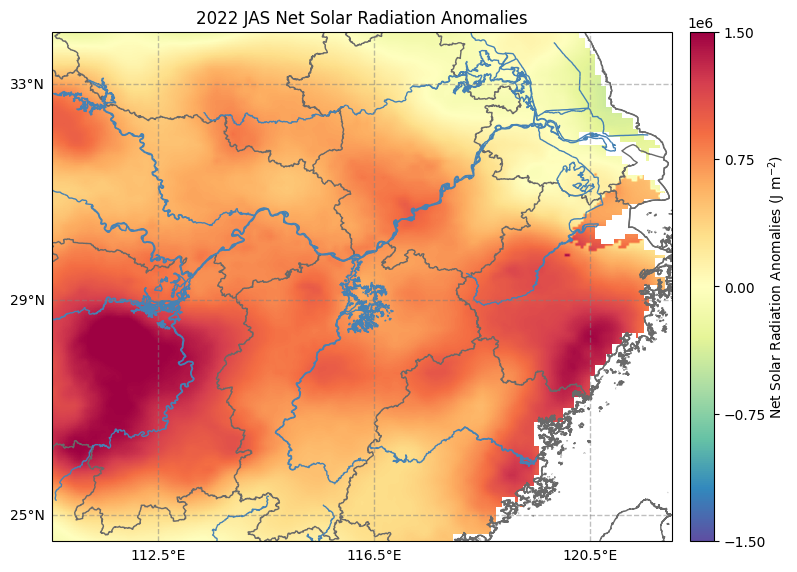

In [32]:
data = ds_ano789['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5*10**6
vmin=-1.5*10**6
cmap = plt.get_cmap('Spectral_r')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS Net Solar Radiation Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. Net Solar Radiation Anomalies')

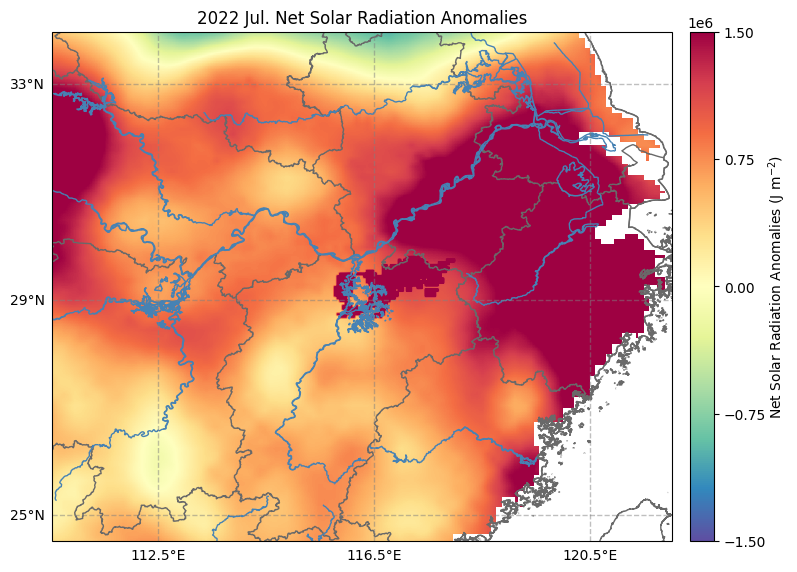

In [51]:
data = ds_ano7['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5*10**6
vmin=-1.5*10**6
cmap = plt.get_cmap('Spectral_r')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. Net Solar Radiation Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Aug. Net Solar Radiation Anomalies')

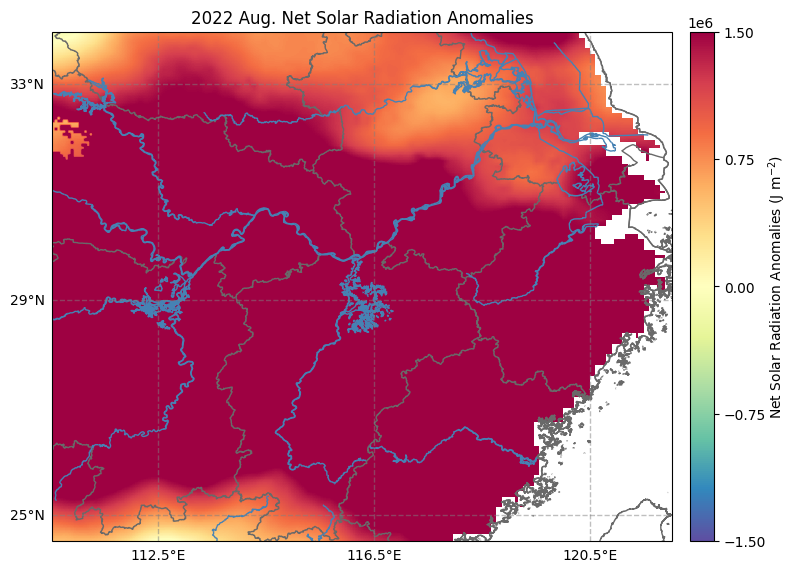

In [52]:
data = ds_ano8['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5*10**6
vmin=-1.5*10**6
cmap = plt.get_cmap('Spectral_r')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Aug. Net Solar Radiation Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. Net Solar Radiation Anomalies')

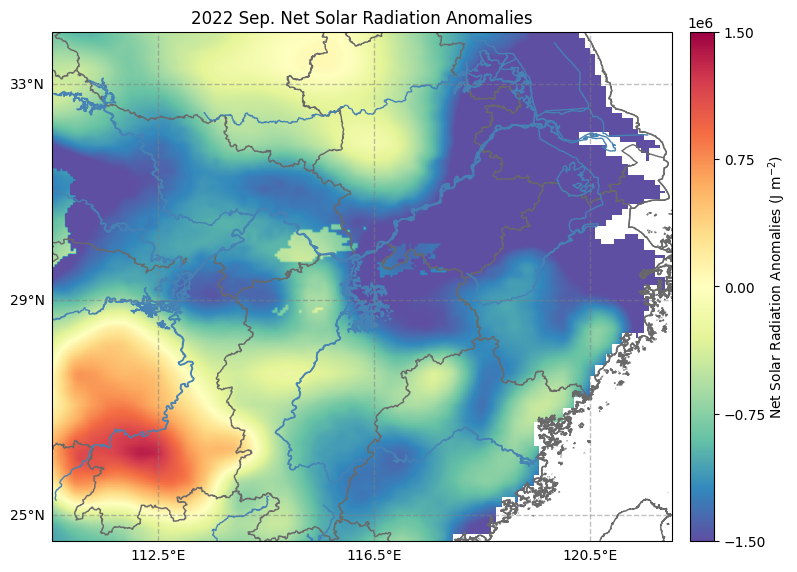

In [53]:
data = ds_ano9['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5*10**6
vmin=-1.5*10**6
cmap = plt.get_cmap('Spectral_r')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. Net Solar Radiation Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jun. Net Solar Radiation Anomalies')

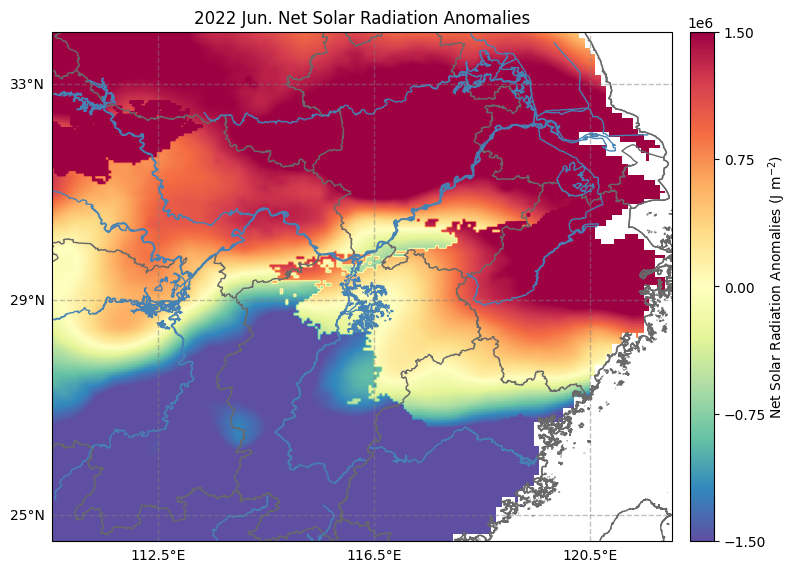

In [59]:
data = ds_ano6['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5*10**6
vmin=-1.5*10**6
cmap = plt.get_cmap('Spectral_r')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('Net Solar Radiation Anomalies (J m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jun. Net Solar Radiation Anomalies')

## veg. type

In [33]:
mask = xr.open_dataset('/portal1/dell/li-b/LC_IGBP_2022_epsg4326.tif')


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
array_1b = vari_b.ravel()
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('forest', np.nanmean(vari_b), pv)
ds_tree = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 12) | (qc_a == 14)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('crop', np.nanmean(vari_b), pv)
ds_crop = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})

forest 665977.8654773749 0.0585869360214893
crop 451052.9318863899 0.0585869360214893


In [42]:
def exclude_sichuan(ds_full):
    arr = ds_full['vari'].values.copy()
    arr[:80,:51] = np.nan
    ds_ex = xr.Dataset({'vari': (['lat','lon'], arr)},
                      coords={ 
                                'lat': (['lat'], ds_full.lat.values),
                        'lon': (['lon'], ds_full.lon.values),})
    return ds_ex

ds_tree1 = exclude_sichuan(ds_tree)
ds_crop1 = exclude_sichuan(ds_crop)

In [34]:
import pyhdf
from pyhdf.SD import SD, SDC  

f = SD('/portal1/dell/li-b/MCD12C1.A2022001.061.2023244164746.hdf', SDC.READ)
# f.datasets()
newlat = np.linspace(89.975, -89.975, 3600) ## care about the order of lat and lon
newlon = np.linspace(-179.975, 179.975, 7200)

varis = f.select('Land_Cover_Type_1_Percent')[:,:,1]
ds_per1 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,2]
ds_per2 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,4]
ds_per4 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,5]
ds_per5 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,12]
ds_per12 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,14]
ds_per14 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

arrl1 = ds_per1['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl2 = ds_per2['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl4 = ds_per4['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl5 = ds_per5['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl12 = ds_per12['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl14 = ds_per14['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values

arr_p = arrl1 + arrl2 + arrl4 + arrl5
arr_p1 = arrl12 + arrl14


dem = xr.open_dataset('/portal1/dell/li-b/dem0.05.nc')
dems = dem['vari'].sel(time='2022-12-31').values

In [47]:
from scipy.stats import mode

x_1d_data = arr_p1.ravel()
y_1d_data = dems.ravel()
vari_b = ds_crop['vari'].values
z_1d_data = vari_b.ravel()

x_1d = arr_p[~np.isnan(arr_p1)].ravel()
y_1d = dems[~np.isnan(dems)].ravel()
z_1d = vari_b[~np.isnan(vari_b)].ravel()

bins = 100
x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(1000, decimals=1), bins)
x_gap = (x.max()-x.min())/bins
y_gap = (y.max()-y.min())/bins
out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('dem',y),('cropland',x)])

for i in range(bins):
    for j in range(bins):
        index = np.argwhere(
            (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
        ).ravel()
        sel = z_1d_data[index]
        if len(sel) == 0:
            out_2d_arr[i][j] = np.nan
        else:
            results = mode(sel)
            out_2d_arr[i][j] = results.mode

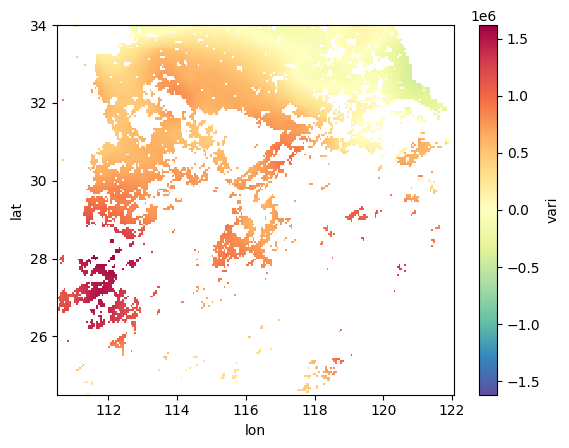

In [48]:
ds_crop['vari'].plot(cmap='Spectral_r')

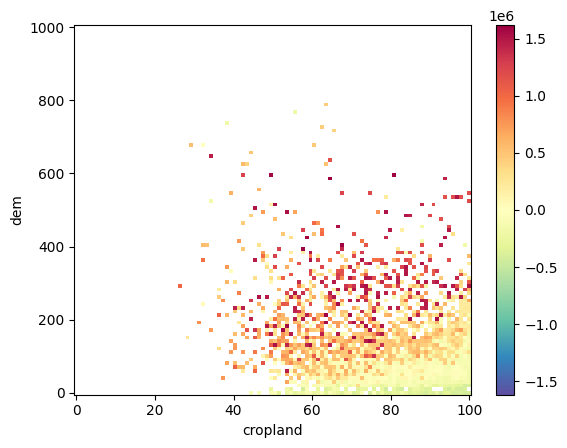

In [49]:
out_2d_arr.plot(cmap='Spectral_r')

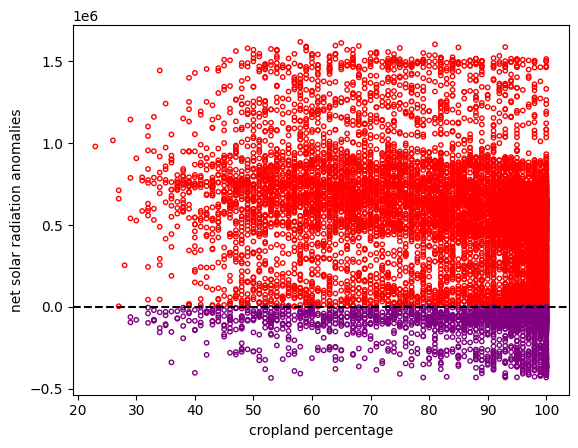

In [50]:
plt.scatter(x_1d_data[z_1d_data >= 0], z_1d_data[z_1d_data >= 0], s=10, facecolors='none', edgecolors='red')
plt.scatter(x_1d_data[z_1d_data < 0], z_1d_data[z_1d_data < 0], s=10, facecolors='none', edgecolors='purple')
plt.xlabel('cropland percentage')
plt.ylabel('net solar radiation anomalies')
plt.axhline(y=0, color='black', linestyle='--')